<a href="https://colab.research.google.com/github/NataliaBlueCloud/Inband_telemetry_design/blob/main/Cochrams_ofc_example_3paths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages("simmer")
install.packages("SciViews")
install.packages("igraph")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ellipse’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(simmer)
library(SciViews)
library(igraph)
library(readxl)
library(ggplot2)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [ ]:
library("googledrive")
if (file.exists("/usr/local/lib/python3.10/dist-packages/google/colab/_ipython.py")){
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check)
  options(rlang_interactive=TRUE)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.25.0 (2022-06-12 02:20:02 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following object is masked from ‘package:igraph’:

    hierarchy


The following object is masked from ‘package:simmer’:

    clone


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.12.2 (2022-11-11 22:00:03 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following objects are masked from ‘package:simmer’:

    reset, wrap


The fo

In [ ]:
drive_auth(use_oob = TRUE, cache = TRUE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=a26531bdd10436590d86db6864353500&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYa0VFWWxjWWZGWGhhLWJzMENSZnlGZkRQOVdpU1VWNk1LQUgtbTBnVlVrSnBlektZSUpZS214LUhGTTYyZmdudyIsInN0YXRlIjoiYTI2NTMxYmRkMTA0MzY1OTBkODZkYjY4NjQzNTM1MDAifQ==


In [ ]:

drive_download("r_traffic_simulation/func/igraph_function_base.R")
drive_download("r_traffic_simulation/func/igraph_functions.R")
drive_download("r_traffic_simulation/func/general_function_base.R")
#drive_download("r_traffic_simulation/func/simmer_function_base.R")

File downloaded:

• igraph_function_base.R <id: 1jwogeGEqQc27cQAu8fiA1mF-KI9C41pm>

Saved locally as:

• igraph_function_base.R

File downloaded:

• igraph_functions.R <id: 1Vyg5nvBWPkMzuajVkyFELct6G1qmjMdP>

Saved locally as:

• igraph_functions.R

File downloaded:

• general_function_base.R <id: 18dycCYyQDWXi1dDVj22EoJWkeYQy-9qg>

Saved locally as:

• general_function_base.R

File downloaded:

• simmer_function_base.R <id: 1VhPVDrrLi9oEWewDFhx0HVlpPuHO38o5>

Saved locally as:

• simmer_function_base.R



In [ ]:
drive_download("r_traffic_simulation/input_files/Metro_topology_full_Milano.xlsx")


File downloaded:

• Metro_topology_full_Milano.xlsx <id: 1qf9aV3AICULgJEx2D98nInZwKnW8D7dn>

Saved locally as:

• Metro_topology_full_Milano.xlsx



In [ ]:
source("igraph_function_base.R")
source("igraph_functions.R")
source("general_function_base.R")

In [ ]:
file_name <- "Metro_topology_full_Milano.xlsx"

In [ ]:
nodes_info <- read_excel(file_name, sheet = 1)
links_info <- read_excel(file_name, sheet = 2)


#M/M/1 model

##Input data

In [ ]:
N = 1250 #packet size (B)
CapacityGbps = 10 #Gbps

In [ ]:
create_graph_object <- function(links_info, nodes_info, CapacityGbps,  N = 1250) {
  g <- graph.data.frame(links_info, directed = TRUE, vertices = nodes_info)
  E(g)$capacityGbps <- CapacityGbps
  E(g)$Capacity <- E(g)$capacityGbps*10^9/(8*N)
  E(g)$Distance <- E(g)$distanceKm
  E(g)$Definition <- paste0(get.edgelist(g)[,1],"->",get.edgelist(g)[,2])

  return(g)
}


g <- create_graph_object(links_info, nodes_info, CapacityGbps,  N)



In [ ]:
################################plot graph

V(g)$color <- "gray"
V(g)$color[47] <- "yellow" #source node
V(g)$color[c(10,11,12,13,14,15,16,17,18,19)] <- "green" # National COs
E(g)$color <- "gray"

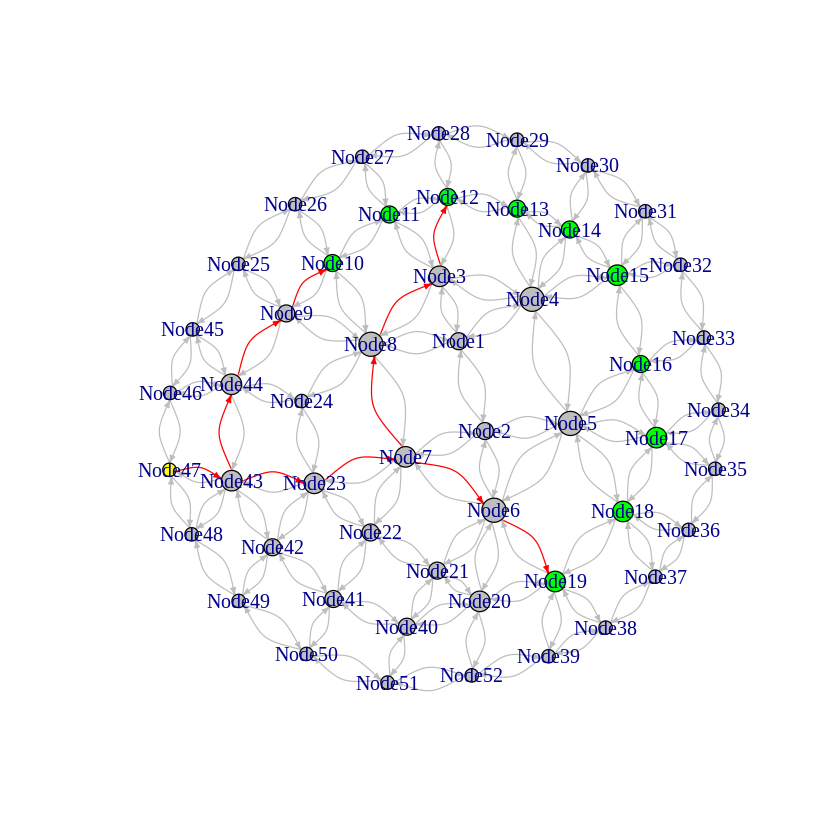

In [ ]:

path_1 <- shortest_paths(g, 47, 10, weights = NULL, output = "both", algorithm = c("automatic"))
path_1 <- E(g)[path_1[["epath"]][[1]]]
E(g)$color[path_1] <- "red"

path_2 <- shortest_paths(g, 47, 19, weights = NULL, output = "both", algorithm = c("automatic"))
path_2 <- E(g)[path_2[["epath"]][[1]]]
E(g)$color[path_2] <- "red"


path_3 <- shortest_paths(g, 47, 12, weights = NULL, output = "both", algorithm = c("automatic"))
path_3 <- E(g)[path_3[["epath"]][[1]]]
E(g)$color[path_3] <- "red"


deg <- degree(g, mode="all")
V(g)$size <- 1 + deg*1.3/2
l <- layout.auto(g)
plot(g, edge.arrow.size=.3, vertex.label = V(g)$name, edge.curved=.5, layout=l)


In [ ]:
E(g)$Load <- runif(length(E(g)), 0.1, 0.95)

There are 3 paths:

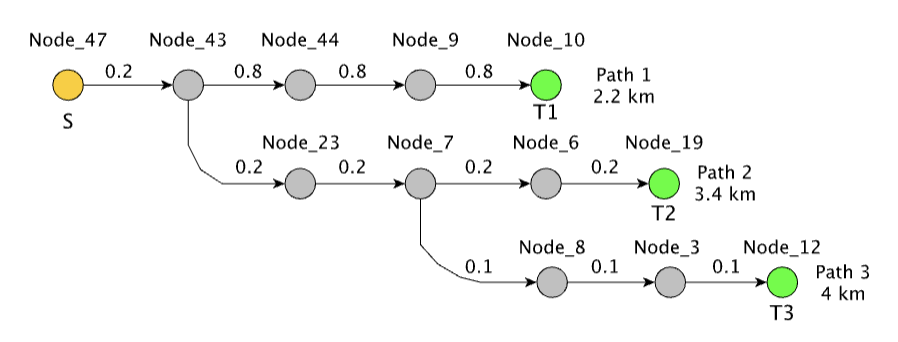

In [ ]:
Load_p1 <- c(0.2,0.8,0.8,0.8)
Load_p2 <- c(0.2,0.2,0.2,0.2,0.2)
Load_p3 <- c(0.2,0.2,0.2,0.1,0.1,0.1)


In [ ]:
E(g)$Load[path_1] <- Load_p1
E(g)$Load[path_2] <- Load_p2
E(g)$Load[path_3] <- Load_p3


In [ ]:
print(paste("Distance path 1",sum(E(g)$Distance[path_1]), "km"))
print(paste("Distance path 2",sum(E(g)$Distance[path_2]), "km"))
print(paste("Distance path 3",sum(E(g)$Distance[path_3]), "km"))

[1] "Distance path 1 2.2 km"
[1] "Distance path 2 3.4 km"
[1] "Distance path 3 4 km"


## Queuing and propagation delays

In [ ]:
############################################################
########################load and delays calculations MM1

traffic_delays_calc <- function(g) {
  E(g)$Traffic <- E(g)$Capacity*E(g)$Load

  E(g)$Ni = E(g)$Load/(1-E(g)$Load) # average number of packets in each system
  E(g)$Queue_Delay <- ifelse(E(g)$Traffic == 0, 0, E(g)$Ni/E(g)$Traffic)
  E(g)$Prop_Delay <- 5*10^(-6)*E(g)$Distance
  return(g)
}
g <- traffic_delays_calc(g)

In [ ]:
rexp_for_pop <- function(rate){
  pop_number = 50000
  return(rexp(n=pop_number,rate))
}


##Simulation of 50k population

###Path 1

In [ ]:
x <- 1/E(g)$Queue_Delay[path_1]

In [ ]:
traffic_path_1 <-  lapply(x, rexp_for_pop)

In [ ]:
# path 1: 4 links at 10Gb/s loads c(0.2,0.9,0.9,0.9), distance = 2km
path1_delays = Reduce("+", traffic_path_1)  + sum(E(g)$Prop_Delay[path_1]) # in s
path1_delays_us <- path1_delays*1e6# in us
mean(path1_delays_us)

[1] 27.2555

###Path 2

In [ ]:
x <- 1/E(g)$Queue_Delay[path_2]

In [ ]:
traffic_path_2 <-  lapply(x, rexp_for_pop)

In [ ]:
# path 2: 5 links at 10Gb/s loads c(0.2,0.2,0.2,0.2,0.2), distance = 3.4km
path2_delays = Reduce("+", traffic_path_2)  + sum(E(g)$Prop_Delay[path_2]) # in s
path2_delays_us <- path2_delays*1e6# in us
mean(path2_delays_us)

[1] 23.25762

###Path 3

In [ ]:
x <- 1/E(g)$Queue_Delay[path_3]

In [ ]:
traffic_path_3 <-  lapply(x, rexp_for_pop)

In [ ]:
# path 3: 6 links at 10Gb/s loads c(0.2,0.2,0.2,0.2,0.1,0.1), distance = 4.0 km
path3_delays = Reduce("+", traffic_path_3)  + sum(E(g)$Prop_Delay[path_3]) # in s
path3_delays_us <- path3_delays*1e6# in us
mean(path3_delays_us)

[1] 27.08814

###PDF function of delays

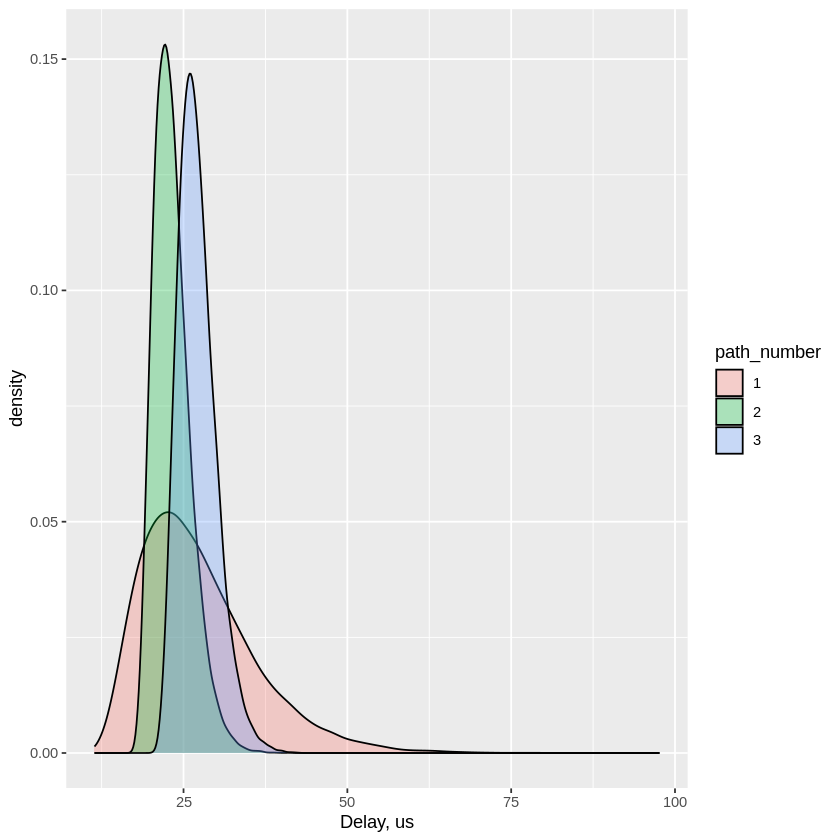

In [ ]:
df <- data.frame(delay_value = c(path1_delays,path2_delays,path3_delays),
path_number = c(rep("1",length(path1_delays)),rep("2",length(path2_delays)),rep("3",length(path3_delays))))

p1 <- ggplot(data=df, aes(x=delay_value*1e6, group=path_number, fill=path_number)) +
  geom_density(adjust=1.5, alpha=.3) + xlab("Delay, us")
#+ xlim(0, 100)

p1

##Results

In [ ]:
threshold_us <- 27 #us

In [ ]:
n_exp <- 100

In [ ]:
table_to_df <- function(path_delays, threshold_us){
  df_p <- as.data.frame(table(path_delays*1e6<threshold_us, useNA = "always"))
  df_p$Var1 <- as.logical(df_p$Var1)
  df_p$Var1[2] = ifelse(df_p$Var1[1] == 1, 0, 1)
  return(df_p)
}

In [ ]:
calc_results <- function(traffic_path_1, traffic_path_2,traffic_path_3, g, threshold_us,n_samples, n_exp)
{
  results <- c()
  percent_below_thr_p1 <- c()
  percent_below_thr_p2 <- c()
  percent_below_thr_p3 <- c()


  for (exp in 1:n_exp)
  {
    path1_delays = sum(E(g)$Prop_Delay[path_1]) +
      sample(traffic_path_1[[1]], size=n_samples, replace=F) +
      sample(traffic_path_1[[2]], size=n_samples, replace=F) +
      sample(traffic_path_1[[3]], size=n_samples, replace=F) +
      sample(traffic_path_1[[4]], size=n_samples, replace=F) # in s
    path2_delays = sum(E(g)$Prop_Delay[path_2]) +
      sample(traffic_path_2[[1]], size=n_samples, replace=F) +
      sample(traffic_path_2[[2]], size=n_samples, replace=F) +
      sample(traffic_path_2[[3]], size=n_samples, replace=F) +
      sample(traffic_path_2[[4]], size=n_samples, replace=F) +
      sample(traffic_path_2[[5]], size=n_samples, replace=F) # in s
    path3_delays = sum(E(g)$Prop_Delay[path_3]) +
      sample(traffic_path_3[[1]], size=n_samples, replace=F) +
      sample(traffic_path_3[[2]], size=n_samples, replace=F) +
      sample(traffic_path_3[[3]], size=n_samples, replace=F) +
      sample(traffic_path_3[[4]], size=n_samples, replace=F) +
      sample(traffic_path_3[[5]], size=n_samples, replace=F) +
      sample(traffic_path_3[[6]], size=n_samples, replace=F) # in s

    percent_below_thr_p1[exp] <- length(path1_delays[path1_delays*1e6 < threshold_us])/length(path1_delays)*100
    percent_below_thr_p2[exp] <- length(path2_delays[path2_delays*1e6 < threshold_us])/length(path2_delays)*100
    percent_below_thr_p3[exp] <- length(path3_delays[path3_delays*1e6 < threshold_us])/length(path3_delays)*100

    df_p1 <- table_to_df(path1_delays, threshold_us)
    df_p1 <- df_p1[order(df_p1$Var1),]
    df_p2 <- table_to_df(path2_delays, threshold_us)
    df_p2 <- df_p2[order(df_p2$Var1),]
    df_p3 <- table_to_df(path3_delays, threshold_us)
    df_p3 <- df_p3[order(df_p3$Var1),]
    results[exp] <- which.max(c(df_p1$Freq[2],df_p2$Freq[2],df_p3$Freq[2]))
  }
  print("% below threshold:")
  print(mean(percent_below_thr_p1[exp]))
  print(mean(percent_below_thr_p2[exp]))
  print(mean(percent_below_thr_p3[exp]))
  print("mean:")
  print(mean(path1_delays))
  print(mean(path2_delays))
  print(mean(path3_delays))
  return(list(results,percent_below_thr_p1,percent_below_thr_p2,percent_below_thr_p3))
}

In [ ]:
c(results_10p, percent_below_thr_p1_10p, percent_below_thr_p2_10p ,percent_below_thr_p3_10p) := calc_results(traffic_path_1, traffic_path_2,traffic_path_3, g, threshold_us, n_samples = 10, n_exp)


[1] "% below threshold:"
[1] 50
[1] 70
[1] 80
[1] "mean:"
[1] 2.530008e-05
[1] 2.422097e-05
[1] 2.643664e-05


In [ ]:
c(results_164p, percent_below_thr_p1_164p, percent_below_thr_p2_164p ,percent_below_thr_p3_164p) := calc_results(traffic_path_1, traffic_path_2,traffic_path_3, g, threshold_us, n_samples =164, n_exp)

[1] "% below threshold:"
[1] 50.60976
[1] 90.85366
[1] 54.26829
[1] "mean:"
[1] 2.853125e-05
[1] 2.315823e-05
[1] 2.693637e-05


In [ ]:
c(results_41p, percent_below_thr_p1_41p, percent_below_thr_p2_41p ,percent_below_thr_p3_41p) := calc_results(traffic_path_1, traffic_path_2,traffic_path_3, g, threshold_us, n_samples = 41, n_exp)

[1] "% below threshold:"
[1] 63.41463
[1] 82.92683
[1] 51.21951
[1] "mean:"
[1] 2.530374e-05
[1] 2.35561e-05
[1] 2.695749e-05


In [ ]:
c(results_452p, percent_below_thr_p1_452p, percent_below_thr_p2_452p , percent_below_thr_p3_452p) := calc_results(traffic_path_1, traffic_path_2,traffic_path_3, g, threshold_us, n_samples = 452, n_exp)

[1] "% below threshold:"
[1] 52.43363
[1] 89.15929
[1] 56.19469
[1] "mean:"
[1] 2.768641e-05
[1] 2.342564e-05
[1] 2.697036e-05


In [ ]:
c(results_50kp, percent_below_thr_p1_50kp, percent_below_thr_p2_50kp ,percent_below_thr_p3_50kp) := calc_results(traffic_path_1, traffic_path_2,traffic_path_3, g, threshold_us, n_samples = 50000, n_exp = 1)

[1] "% below threshold:"
[1] 56.302
[1] 90.094
[1] 54.058
[1] "mean:"
[1] 2.72555e-05
[1] 2.325762e-05
[1] 2.708814e-05


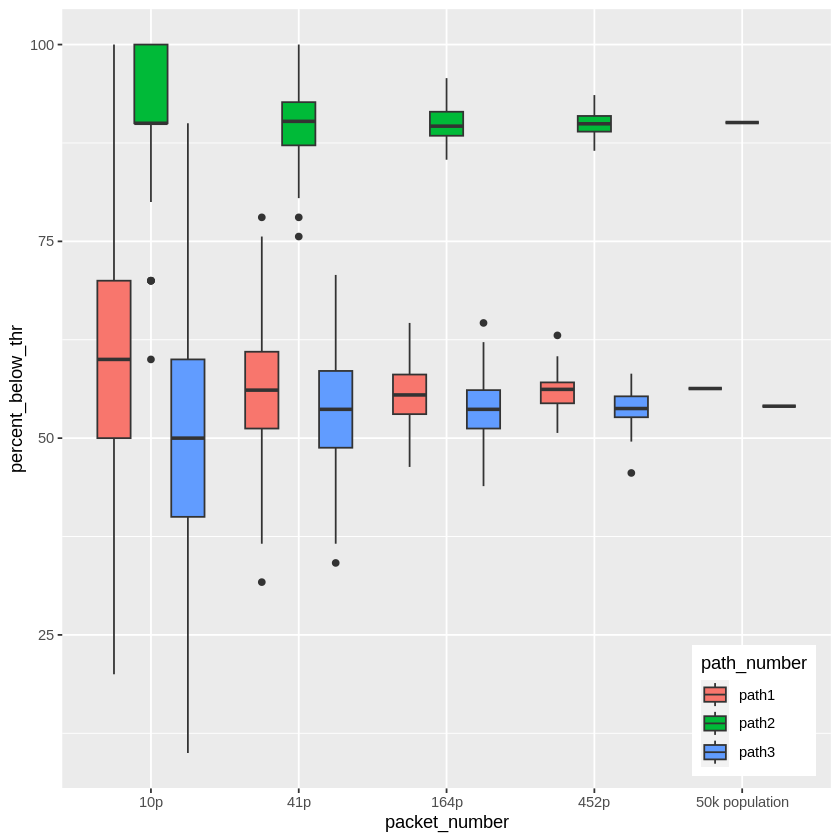

In [ ]:
path_number_41p = c(rep("path1",length(percent_below_thr_p1_41p)),rep("path2",length(percent_below_thr_p2_41p)), rep("path3",length(percent_below_thr_p3_41p)))
path_number_10p = c(rep("path1",length(percent_below_thr_p1_10p)),rep("path2",length(percent_below_thr_p2_10p)), rep("path3",length(percent_below_thr_p3_10p)))
path_number_164p = c(rep("path1",length(percent_below_thr_p1_164p)),rep("path2",length(percent_below_thr_p2_164p)), rep("path3",length(percent_below_thr_p3_164p)))
path_number_452p = c(rep("path1",length(percent_below_thr_p1_452p)),rep("path2",length(percent_below_thr_p2_452p)), rep("path3",length(percent_below_thr_p3_452p)))
path_number_50kp = c(rep("path1",length(percent_below_thr_p1_50kp)),rep("path2",length(percent_below_thr_p2_50kp)), rep("path3",length(percent_below_thr_p3_50kp)))


data=data.frame(percent_below_thr = c(percent_below_thr_p1_10p,percent_below_thr_p2_10p,percent_below_thr_p3_10p,
percent_below_thr_p1_41p, percent_below_thr_p2_41p, percent_below_thr_p3_41p,
percent_below_thr_p1_164p, percent_below_thr_p2_164p, percent_below_thr_p3_164p,
percent_below_thr_p1_452p, percent_below_thr_p2_452p, percent_below_thr_p3_452p,
percent_below_thr_p1_50kp, percent_below_thr_p2_50kp, percent_below_thr_p3_50kp),
 path_number = c(path_number_10p, path_number_41p, path_number_164p,path_number_452p, path_number_50kp),
 packet_number = c(rep("10p",length(path_number_10p)),rep("41p",length(path_number_41p)),rep("164p",length(path_number_164p)),rep("452p",length(path_number_452p)),rep("50k population",length(path_number_50kp)) ))

# grouped boxplot

data$packet_number <- factor(data$packet_number , levels=c("10p", "41p", "164p", "452p", "50k population"))
ggplot(data, aes(x=packet_number, y=percent_below_thr, fill=path_number)) + geom_boxplot() + theme(legend.position = c(0.9, 0.1))

Warning message in arrows(x, upper, x, lower, angle = 90, code = 3, length = length, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x, upper, x, lower, angle = 90, code = 3, length = length, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x, upper, x, lower, angle = 90, code = 3, length = length, :
“zero-length arrow is of indeterminate angle and so skipped”


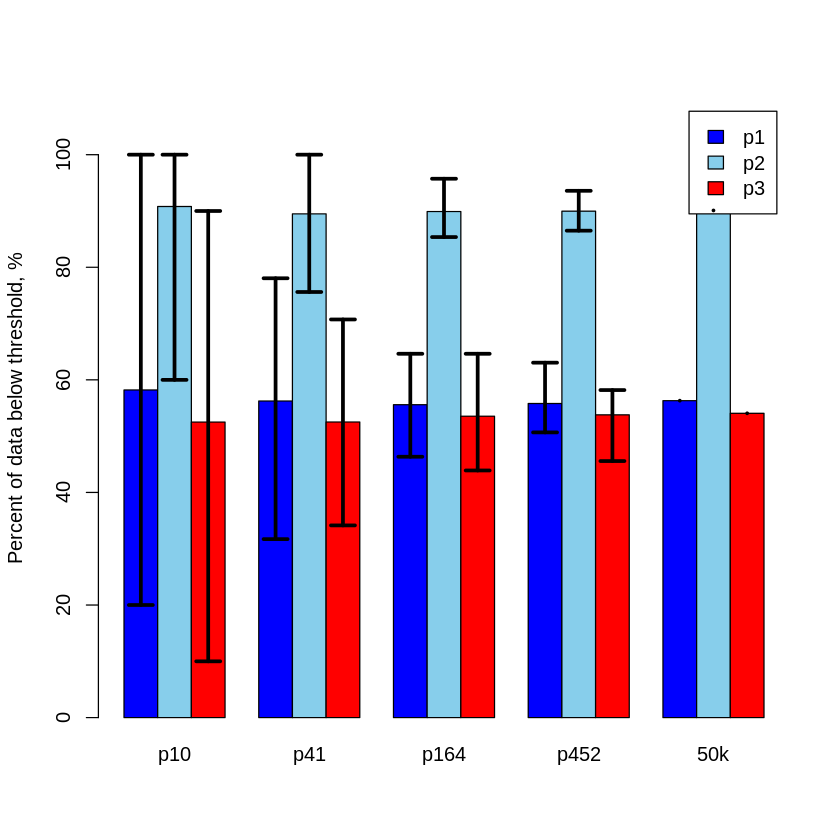

In [ ]:
bilan <- matrix(c(mean(percent_below_thr_p1_10p),mean(percent_below_thr_p2_10p),mean(percent_below_thr_p3_10p),
mean(percent_below_thr_p1_41p),mean(percent_below_thr_p2_41p),mean(percent_below_thr_p3_41p),
mean(percent_below_thr_p1_164p),mean(percent_below_thr_p2_164p),mean(percent_below_thr_p3_164p),
mean(percent_below_thr_p1_452p),mean(percent_below_thr_p2_452p),mean(percent_below_thr_p3_452p),
mean(percent_below_thr_p1_50kp),mean(percent_below_thr_p2_50kp),mean(percent_below_thr_p3_50kp)), nrow = 3, ncol = 5)
rownames(bilan) <- c("p1","p2","p3")
colnames(bilan) <- c("p10","p41","p164","p452", "50k")


stdev_max <- matrix(c(max(percent_below_thr_p1_10p),max(percent_below_thr_p2_10p),max(percent_below_thr_p3_10p),
max(percent_below_thr_p1_41p),max(percent_below_thr_p2_41p),max(percent_below_thr_p3_41p),
max(percent_below_thr_p1_164p),max(percent_below_thr_p2_164p),max(percent_below_thr_p3_164p),
max(percent_below_thr_p1_452p),max(percent_below_thr_p2_452p),max(percent_below_thr_p3_452p),
max(percent_below_thr_p1_50kp),max(percent_below_thr_p2_50kp),max(percent_below_thr_p3_50kp)), nrow = 3, ncol = 5)
rownames(stdev_max) <- c("p1","p2","p3")
colnames(stdev_max) <- c("p10","p41","p164","p452", "50k")


stdev_min <- matrix(c(min(percent_below_thr_p1_10p),min(percent_below_thr_p2_10p),min(percent_below_thr_p3_10p),
min(percent_below_thr_p1_41p),min(percent_below_thr_p2_41p),min(percent_below_thr_p3_41p),
min(percent_below_thr_p1_164p),min(percent_below_thr_p2_164p),min(percent_below_thr_p3_164p),
min(percent_below_thr_p1_452p),min(percent_below_thr_p2_452p),min(percent_below_thr_p3_452p),
min(percent_below_thr_p1_50kp),min(percent_below_thr_p2_50kp),min(percent_below_thr_p3_50kp)), nrow = 3, ncol = 5)
rownames(stdev_min) <- c("p1","p2","p3")
colnames(stdev_min) <- c("p10","p41","p164","p452", "50k")


#A function to add arrows on the chart
error.bar <- function(x, y, upper, lower=upper, length=0.1,...){
  arrows(x,upper, x, lower, angle=90, code=3, length=length, col = "black", lwd = 3 )
}

#I am ready to add the error bar on the plot using my "error bar" function !
ze_barplot <- barplot(bilan , beside=T , legend.text=T,col=c("blue" , "skyblue", "red") , ylim=c(0,110) , ylab="Percent of data below threshold, %")
error.bar(ze_barplot, bilan, stdev_max, stdev_min)


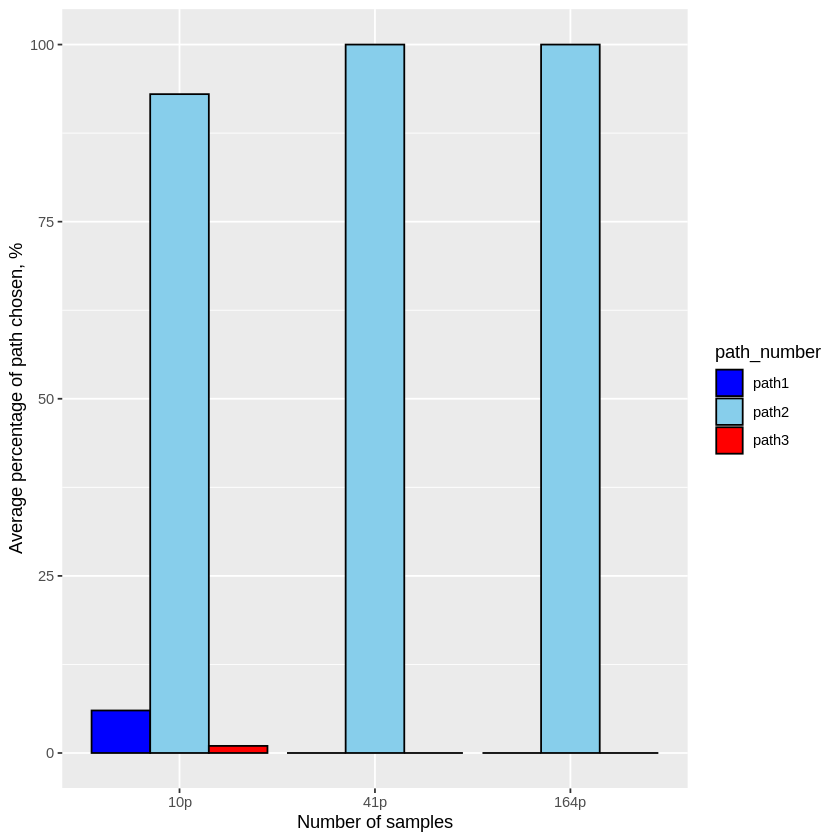

In [ ]:
path_number_41p = c(rep("path1",length(percent_below_thr_p1_41p)),rep("path2",length(percent_below_thr_p2_41p)), rep("path3",length(percent_below_thr_p3_41p)))
path_number_10p = c(rep("path1",length(percent_below_thr_p1_10p)),rep("path2",length(percent_below_thr_p2_10p)), rep("path3",length(percent_below_thr_p3_10p)))
path_number_164p = c(rep("path1",length(percent_below_thr_p1_164p)),rep("path2",length(percent_below_thr_p2_164p)), rep("path3",length(percent_below_thr_p3_164p)))


data=data.frame(value = c(length(results_10p[results_10p == 1])*100/n_exp,length(results_10p[results_10p == 2])*100/n_exp,length(results_10p[results_10p == 3])*100/n_exp,
length(results_41p[results_41p == 1])*100/n_exp,length(results_41p[results_41p == 2])*100/n_exp,length(results_41p[results_41p == 3])*100/n_exp,
length(results_164p[results_164p == 1])*100/n_exp,length(results_164p[results_164p == 2])*100/n_exp,length(results_164p[results_164p == 3])*100/n_exp),
path_number = c("path1","path2","path3",
"path1","path2","path3",
"path1","path2","path3"),
packet_number = c(rep("10p",3),rep("41p",3),rep("164p",3)))
data$packet_number <- factor(data$packet_number , levels=c("10p", "41p", "164p"))

# grouped boxplot
ggplot(data, aes(x=packet_number, y=value, fill=path_number)) +
geom_bar(stat = "identity",position=position_dodge(), size = 0.5, color = "black") +
scale_fill_manual(values = c("blue" , "skyblue", "red") )  + ylab("Average percentage of path chosen, %") +
xlab("Number of samples")
